<a href="https://colab.research.google.com/github/study-groups/nlp-study-group/blob/master/TwitterSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Goals**

This project effectively aims to build a Sentiment Classifer using an LSTM Neural Network . Within that scope I have the following sub goals:


1.   Evaluate the difference in error between an LSTM NN trained on a full tweet, and one trained on a preprocessed tweet.
2.   Evaluate the impact of removing stop words during preprocessing.





# **Imports**

In [0]:
# sklearn analytics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Models
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import Birch

# Text Preprocessing
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,\
    TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline


# General
import warnings
import numpy as np
import pandas as pd
import nltk
import random
import os
import re
import string
import statsmodels.api as sm
from os import path
from PIL import Image
from time import time


# NLP
from nltk import sent_tokenize, word_tokenize
from nltk.util import ngrams
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = stopwords.words('english')
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS
from subprocess import check_output
from collections import Counter
import spacy
nlp = spacy.load('en')

# Set Plot Theme
sns.set_palette([
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#551A8B",
])

# Warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


!pip install emoji
import emoji

from textblob import TextBlob

!pip install tweet-preprocessor
import preprocessor as p

!pip install plotly
import plotly

#!pip install -q keras
#import keras

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
import torchvision


# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Mounted at /content/gdrive
CUDA is available!  Training on GPU ...


In [0]:
# Read and Peak at Data
df = pd.read_csv('/content/gdrive/My Drive/Data Science/trump.csv', sep='\t') 

# Extracting Missing Count and Unique Count by Column
unique_count = []
for x in df.columns:
    unique_count.append([x, len(df[x].unique()), df[x].isnull().sum()])

# Missing Values
print("Missing Values: {}".format(df.isnull().sum().sum()))

# Data Dimensions
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))

# Convert to tweet to string
df['tweet'] = df['tweet'].astype(str)

# Create New Variables:
# Word Length
df["word_count"] = df['tweet'].str.split().apply(len)
# Character Length
df["character_count"] = df['tweet'].apply(len)

Missing Values: 184956
Dataframe Dimension: 430228 Rows, 5 Columns


In [0]:
df.head()

,time,tweet,id,username,location,word_count,character_count
0,1547856694.7658603,'RT @SethAbramson: In case you missed it: what...,79549,SmithEckert13,"Fort Wayne, IN",25,155
1,1547856694.7953787,'RT @RonWyden: Incredible. More luxury travel ...,79550,QueenTAG,"Scotts Valley, CA",22,149
2,1547856694.8134415,'President Trump Directed Michael Cohen To Lie...,79551,vkrgz,Dünyanın içinden,16,125
3,1547856694.8526797,'RT @TeaPainUSA: Tea would wager that Trump in...,79552,ChazGohVan,Jupiter UNIVERSE,26,147
4,1547856694.904921,'RT @BruceBartlett: There is one person in Ame...,79553,JudyPrincz,"Manhattan, NY",24,147


In [0]:
df.describe()

,word_count,character_count
count,430228.000000,430228.000000
mean,18.674238,122.972138
std,6.134861,33.739280
min,1.000000,1.000000
25%,16.000000,122.000000
50%,20.000000,140.000000
75%,23.000000,140.000000
max,37.000000,258.000000


In [0]:
df.tweet[5000]

'RT @Chef_Epsimos: @shannonrwatts Everyone should start tweeting trump #PresidentPelosi'

# **Data Cleaning**

In [0]:

# Importing SKLearn's list of stopwords and 
# then appending with my own words
stop = text.ENGLISH_STOP_WORDS
      
# Basic text cleaning function that also removes stopwords
def remove_noise(text):

    # Remove Mentions
   # text = text.apply(lambda x: re.compile('\#').sub('', re.compile(
        #'RT @').sub('@', x, count=1).strip()))
    
    # Remove URLs
    text = text.str.replace('https?://[A-Za-z0-9./]+','')
    
    # Keep Hashtag text
    text = text.str.replace("[^a-zA-Z]", " ")
    
    # Make lowercase
    text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))

    # Remove whitespaces
    text = text.apply(lambda x: " ".join(x.strip() for x in x.split()))

    # Remove special characters
    text = text.apply(lambda x: "".join(
        [" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))

    # Remove punctuation
    text = text.str.replace('[^\w\s]', '')

    # Remove numbers
    text = text.str.replace('\d+', '')

    # Remove Stopwords
    text = text.apply(lambda x: ' '.join(
        [word for word in x.split() if word not in (stop)]))

    # Convert to string
    text = text.astype(str)

    return text
   
# Function to remove RT @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt  
  

# remove  RT: @user
df['filtered_tweet'] = np.vectorize(
    remove_pattern)(df['tweet'], "RT @[\w]*")

# Apply cleaner function
df['filtered_tweet'] = remove_noise(df['filtered_tweet'])

df = df.drop(['time', 'id', 'username', 'location'], axis=1)
df.head(5)

,tweet,word_count,character_count,filtered_tweet
0,'RT @SethAbramson: In case you missed it: what...,25,155,case missed fuss tonight retweet think followe...
1,'RT @RonWyden: Incredible. More luxury travel ...,22,149,incredible luxury travel trump administration ...
2,'President Trump Directed Michael Cohen To Lie...,16,125,president trump directed michael cohen lie con...
3,'RT @TeaPainUSA: Tea would wager that Trump in...,26,147,tea wager trump instructed folks lie congress ...
4,'RT @BruceBartlett: There is one person in Ame...,24,147,person america trump chose rupert murdoch medi...


In [0]:
#Second Cleaning Function that keeps stopwords
def extract_text(text):
    
    # Convert to string
    text = text.astype(str)
    
    # Remove URLs
    text = text.str.replace('https?://[A-Za-z0-9./]+','')
    
    # Keep Hashtag text
    text = text.str.replace("[^a-zA-Z]", " ")
    
    # Make lowercase
    text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))

    # Remove whitespaces
    text = text.apply(lambda x: " ".join(x.strip() for x in x.split()))

    # Remove special characters
    text = text.apply(lambda x: "".join(
        [" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))

    # Remove punctuation
    text = text.str.replace('[^\w\s]', '')

    # Remove numbers
    text = text.str.replace('\d+', '')
    
    #Remove 1-2 letter clutter remnants
    text = text.apply(lambda x: re.sub(r'\b\w{1,2}\b', '', x))

    return text

# remove  RT: @user
df['clean'] = np.vectorize(remove_pattern)(df['tweet'], "RT @[\w]*")


# Applying function to data
df['clean'] = extract_text(df['clean'])


In [0]:
print(df.tweet[5])
print(df.clean[5])

'RT @cher: trump\u2019s A CROOK &amp; LIAR,IF HE WAS THE HEAD OF ANY COMPANY HE WOULD BE FIRED.THE IMMEDIATE CRISIS, \n800,000.00 PPL ARE LOSING THE L\u2026'
trump    crook amp liar   was the head  any company  would  fired the immediate crisis  ppl are losing the  


# Sentiment Labelling

The sentiment property of Texblob returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. We will use this to label tweets as positive, neutral, or negative. 

I will label anything with a polarity of exactly zero as neutral and remove the data rows with that label, leaving only polar data points. Then we can see if this method of labeling works for training a classifier.

In [0]:
def analyze_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

# Create a column with the result of the analysis:
df['SA'] = np.array(
    [analyze_sentiment(tweet) for tweet in df['filtered_tweet']])

df['SA2'] = np.array(
    [analyze_sentiment(tweet) for tweet in df['clean']])

df.head()

,tweet,word_count,character_count,filtered_tweet,clean,SA,SA2
0,'RT @SethAbramson: In case you missed it: what...,25,155,case missed fuss tonight retweet think followe...,case you missed what all the fuss about ton...,0,0
1,'RT @RonWyden: Incredible. More luxury travel ...,22,149,incredible luxury travel trump administration ...,incredible more luxury travel from the trump a...,1,1
2,'President Trump Directed Michael Cohen To Lie...,16,125,president trump directed michael cohen lie con...,president trump directed michael cohen lie c...,0,0
3,'RT @TeaPainUSA: Tea would wager that Trump in...,26,147,tea wager trump instructed folks lie congress ...,tea would wager that trump instructed all his ...,0,-1
4,'RT @BruceBartlett: There is one person in Ame...,24,147,person america trump chose rupert murdoch medi...,there one person america who could somethin...,0,0


In [0]:
print(df.tweet[3])

'RT @TeaPainUSA: Tea would wager that Trump instructed all his folks to lie to Congress because he knew Nunes and his other GOP imps and dem\u2026'


Looking at the Tweet at index 3 we can see there is a polarity differnce between the filtered tweet and the clean tweet. This could mean that stop words impact the way Textblob assess polarity. 

Intuitively I would call this tweet negative as it is objectively critical. As such, I'll use the SA2 variable as my label.

I'm going to drop all the neutral tweets since I'm interetsed in binary sentiment classification.

In [0]:
# Make a copy of the data frame for later, and dropping neutral tweets
df2 = df[df.SA2 != 0]

# Dropping neutral tweets
df = df[df.SA != 0]

print('DF has {} rows.'.format(len(df)))
print('DF2 has {} rows.'.format(len(df2)))
print('\n')
print('DF2 has {} negative comments.'.format(
    (df2.SA2 != 0).sum()))
print('DF2 has {} positive comments.'.format(
    (df2.SA2 != 1).sum()))



DF has 238014 rows.
DF2 has 257218 rows.


DF2 has 257218 negative comments.
DF2 has 93343 positive comments.


# **EDA**

First I'm going to do some data organization and trimming to build data frame copies for later. EDA will mostly focus on the full, imbalanced data set.

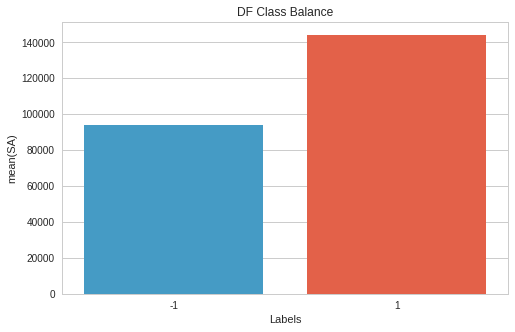

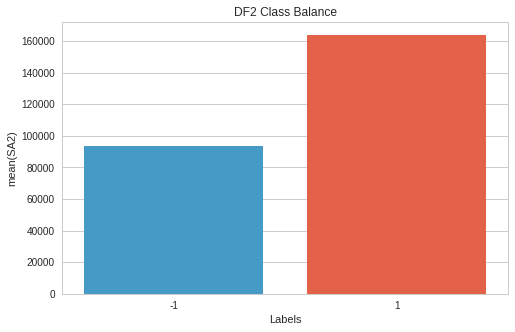

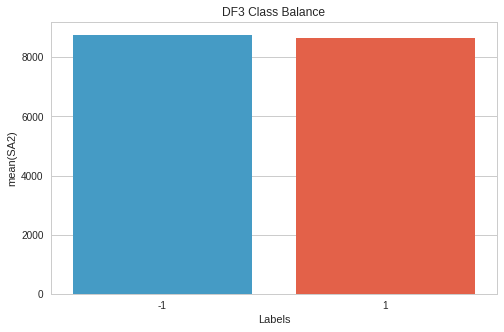

In [0]:
# Removed data to give even batch sizes DF
remove_n = len(df)%50
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df = df.drop(drop_indices)

# Plot the label classes
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.SA.unique(),y=df.SA.value_counts());
ax.set(xlabel='Labels')
ax.set_title('DF Class Balance')

# Removed data to give even batch sizes DF2
remove_n = len(df2)%50
drop_indices2 = np.random.choice(df2.index, remove_n, replace=False)
df2 = df2.drop(drop_indices2)

# Plot the label classes
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df2.SA2.unique(),y=df2.SA2.value_counts());
ax.set(xlabel='Labels')
ax.set_title('DF2 Class Balance')

#Define DF Copy to Reduce
df3 = pd.concat(g.sample(87155) for idx, g in df2.groupby('SA2'))
df3 = df3.sample(frac=.1)

# Removed data to give even batch sizes DF3
remove_n = len(df3)%50
drop_indices3 = np.random.choice(df3.index, remove_n, replace=False)
df3 = df3.drop(drop_indices3)

# Plot the label classes
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df3.SA2.unique(),y=df3.SA2.value_counts());
ax.set(xlabel='Labels')
ax.set_title('DF3 Class Balance')

plt.show()

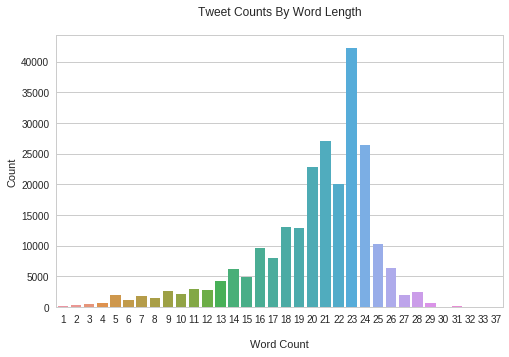

In [0]:
# Exploring tweet word count
z = df.groupby(by=['word_count'], as_index=False).count(
).sort_values(by='SA2', ascending=False)

plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")
ax = sns.barplot(x=z['word_count'], y=z['SA2'], data=z)
plt.xlabel("\nWord Count")
plt.ylabel("Count")
plt.title("Tweet Counts By Word Length\n")
#plt.savefig("Counts By Department.png", dpi =300)
plt.show()

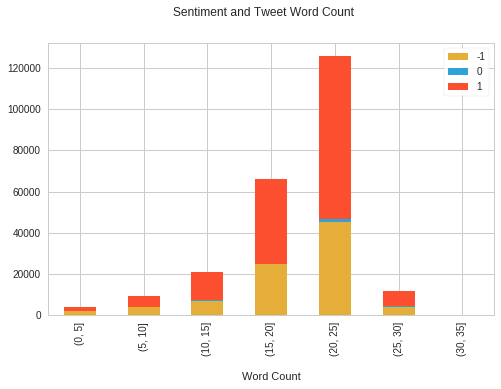

In [0]:
# Exploring Recomendation and age distribution.
colors = color={-1: "#e5ae38",
                0: '#30a2da',
                1: '#fc4f30'}
f, ax = plt.subplots(figsize=(8, 5))
df.groupby(['SA2', pd.cut(df['word_count'], np.arange(0, 40, 5))])\
    .size()\
    .unstack(0)\
    .plot.bar(stacked=True, ax=ax, color=colors.values())
#plt.subplots_adjust(top=.8)
plt.suptitle('Sentiment and Tweet Word Count')
plt.xlabel("\nWord Count")
ax.legend(loc='best', frameon=True)
#plt.savefig("Recommendation and Age.png", dpi =300)
#plt.tight_layout()
plt.show()

We can see similar distribution of word counts, regardless of sentiment. The size difference of the  bars is likely due to the class imbalance we've observed. This could be verified by running the same plot on the trimmed data (DF3).

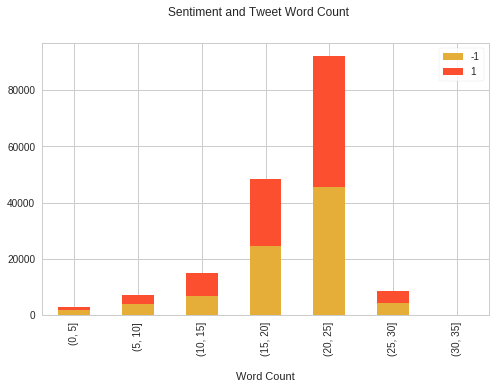

In [0]:
# Exploring Recomendation and age distribution.
colors = color={-1: "#e5ae38",
                1: '#fc4f30'}
f, ax = plt.subplots(figsize=(8, 5))
df3.groupby(['SA2', pd.cut(df3['word_count'], np.arange(0, 40, 5))])\
    .size()\
    .unstack(0)\
    .plot.bar(stacked=True, ax=ax, color=colors.values())
#plt.subplots_adjust(top=.8)
plt.suptitle('Sentiment and Tweet Word Count')
plt.xlabel("\nWord Count")
ax.legend(loc='best', frameon=True)
#plt.savefig("Recommendation and Age.png", dpi =300)
#plt.tight_layout()
plt.show()

Voilà! 

# **TF-IDF**

In [0]:
# convert column of sentiment to list of ints
all_sent = df3.SA2.astype(int).values.tolist()

# 1=positive, 0=negative label conversion
#sent_split = sent_split('\n')
encoded_labels = np.array(
    [1 if sent == 1 else 0 for sent in all_sent])


encoded_labels[:10]

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 1])

In [0]:
X = df3.loc[:, 'clean']
y = encoded_labels
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

t0 = time()
vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=2, stop_words='english')

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.fit_transform(X_test)
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X_train_tfidf.shape)
print()

done in 0.312754s
n_samples: 13050, n_features: 5079



In [0]:
print("Performing dimensionality reduction using LSA")
t0 = time()

svd = TruncatedSVD(600)
#normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd)#, normalizer)

X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.fit_transform(X_test_tfidf)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

print()

Performing dimensionality reduction using LSA
done in 12.852436s
Explained variance of the SVD step: 81%



## **K-Means Clustering**

In [0]:
# Since our target is boolean, we expect 2 clusters.
km = KMeans(n_clusters=2, max_iter=100,
            random_state=42)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X_train_lsa)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
done in 2.997s



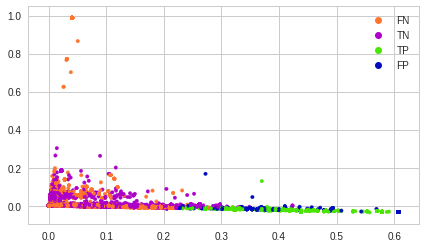


Confusion Matrix:  
 Predicted      0     1    All
True                         
0           6133   455   6588
1           5641   821   6462
All        11774  1276  13050

                    Classification Report 
               precision    recall  f1-score   support

           0       0.52      0.93      0.67      6588
           1       0.64      0.13      0.21      6462

   micro avg       0.53      0.53      0.53     13050
   macro avg       0.58      0.53      0.44     13050
weighted avg       0.58      0.53      0.44     13050



In [0]:

plt.figure(figsize=(7, 4))
# Calculate predicted values.
y_pred = km.fit_predict(X_train_lsa)

# Calculate Error Type
y_error = (y_pred*2)-Y_train

#Define Error Colors
LABEL_COLOR_MAP = {-1: '#FF752E',
                   0:  '#ad00c8',
                   1: '#4ae500', 
                   2: '#000dbf'
                   }
label_color = [LABEL_COLOR_MAP[i] for i in y_error]
label_convert = {-1: 'FN',
                 0: 'TN',
                 1:'TP',
                 2: 'FP'
                 } 
# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1],
            marker='.', c=label_color) 
#Plot the error legend
markers = [
    plt.Line2D([0, 0], [0, 0], color=color,
               marker='o', linestyle=''
               ) for color in LABEL_COLOR_MAP.values()]
plt.legend(markers, label_convert.values(), numpoints=1)
plt.rcParams.update({'font.size': 12})
#plt.savefig("K-Means.png", dpi =300)
plt.show()

# Check the solution against the data.
cm = pd.crosstab(Y_train, y_pred, rownames=['True'], 
                 colnames=['Predicted'], margins=True)
print("\nConfusion Matrix:  \n", cm)
print("\n                    Classification Report \n",
      classification_report(Y_train, y_pred))

In [0]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
t0 = time()
tsne_results_train = tsne.fit_transform(X_train_lsa)
print("done in %0.3fs" % (time() - t0))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 130725 samples in 11.642s...


In [0]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(17.5, 11))
ax = fig.add_subplot(111, projection='3d')

TSNE_color_dict = {0:  '#ad00c8',
                   1: '#4ae500' 
                   #2: '#000dbf'
                   }
TSNE_color = [TSNE_color_dict[i] for i in Y_train]
flatui = ["#4ae500", "#d63900"]

# Data for three-dimensional scattered points
zdata = tsne_results_train[:, 0]
xdata = tsne_results_train[:, 1]
ydata = tsne_results_train[:, 2]
ax.scatter3D(xdata, ydata, zdata, c=TSNE_color)

# rotate the axes and plot
ax.view_init(elev = -15, azim = 45)
plt.title('t-SNE Clustering')
plt.tight_layout()    
#plt.savefig("t_SNE.png", dpi =300)
plt.show()

# **Word2Vec**

In [0]:
from string import punctuation

# convert column of tweets to list of words
all_text = df3.clean.astype(str).values.tolist()
string_text = '\n'.join([word for word in all_text])
tweet_split = string_text.split('\n')
string_text = ' '.join(tweet_split)

# create a list of words
words = string_text.split()

In [0]:
# store as list of lists of words
sentences = []
for sent_str in all_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences.append(tokens)

In [0]:
sentences[0]

['this',
 'point',
 'trump',
 'announces',
 'end',
 'the',
 'shutdown',
 'will',
 'due',
 'his',
 'acknowledgement',
 'pain',
 'and',
 'suffering']

In [0]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences=sentences, size=300, window=5, min_count=5, workers=4, sg=0)


In [0]:
w2v_model.wv.most_similar('bad')

[('aware', 0.8287050724029541),
 ('burned', 0.8248616456985474),
 ('least', 0.7881642580032349),
 ('left', 0.7853484153747559),
 ('happens', 0.7647498846054077),
 ('very', 0.7583795785903931),
 ('exposing', 0.7561557292938232),
 ('day', 0.7526326179504395),
 ('everyone', 0.7495018839836121),
 ('warned', 0.7468767166137695)]

## **Fast Text**

In [0]:
from gensim.models import FastText
fast_model = FastText(
    sentences, size=300, window=5, min_count=5, workers=4,sg=0)

In [0]:
fast_model.wv.most_similar("bad")

[('dad', 0.8990905284881592),
 ('glad', 0.8008184432983398),
 ('way', 0.7807180881500244),
 ('happens', 0.7746290564537048),
 ('sooo', 0.7656075954437256),
 ('afraid', 0.7629728317260742),
 ('baby', 0.7625799775123596),
 ('bash', 0.7607089877128601),
 ('soooo', 0.7492426633834839),
 ('journalism', 0.7421059608459473)]

# **Doc2Vec**

In [0]:
x_d2v = df3.clean
y_d2v = df3.SA2

x_train_d2v, x_validation_and_test_d2v, y_train_d2v, y_validation_and_test_d2v = train_test_split(
    x_d2v, y_d2v, test_size=.02, random_state=42)

x_validation_d2v, x_test_d2v, y_validation_d2v, y_test_d2v = train_test_split(
    x_validation_and_test_d2v, y_validation_and_test_d2v, 
    test_size=.5, random_state=42)

In [0]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

In [0]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result

We'll train with the entire 

In [0]:
all_x = pd.concat([x_train_d2v, x_validation_d2v, x_test_d2v])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [0]:
len(all_x_w2v)

174300

In [0]:
doc2vec_model = Doc2Vec(vector_size=50, min_count=2, epochs=5)
doc2vec_model.build_vocab([x for x in tqdm(all_x_w2v)])

100%|██████████| 174300/174300 [00:00<00:00, 2070777.21it/s]


In [0]:
doc2vec_model.train(
    utils.shuffle([x for x in tqdm(all_x_w2v)]),
                        total_examples=len(all_x_w2v), 
    epochs=doc2vec_model.epochs)
   

100%|██████████| 174300/174300 [00:00<00:00, 2315548.18it/s]


In [0]:
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs
  
train_vecs_d2v = get_vectors(doc2vec_model, x_train_d2v, 50)
validation_vecs_d2v = get_vectors(doc2vec_model, x_validation_d2v, 50)  

In [0]:
# Defining a function to fit and predict ML algorithms
def auto_model(mod, model_name, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    print(model_name)
    acc = cross_val_score(mod, X_train, y_train,
                          scoring="accuracy", cv=5)
    predictions = cross_val_predict(mod, X_train, y_train, cv=5)
    print("Accuracy:", round(acc.mean(), 3))
    cm = pd.crosstab(y_train, predictions, rownames=['True'], 
                 colnames=['Predicted'], margins=True)
    print("\nConfusion Matrix:  \n", cm)
    print("\n                    Classification Report \n",
          classification_report(y_train, predictions))

## **Doc2Vec Classification Models**

In [0]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
auto_model(rfc, "Random Forest Classifier",
           train_vecs_d2v, validation_vecs_d2v, y_train_d2v, y_validation_d2v)

Random Forest Classifier
Accuracy: 0.675

Confusion Matrix:  
 Predicted     -1      1     All
True                           
-1         59614  25791   85405
1          29654  55755   85409
All        89268  81546  170814

                    Classification Report 
               precision    recall  f1-score   support

          -1       0.67      0.70      0.68     85405
           1       0.68      0.65      0.67     85409

   micro avg       0.68      0.68      0.68    170814
   macro avg       0.68      0.68      0.68    170814
weighted avg       0.68      0.68      0.68    170814



In [0]:
# Gaussian Naive Bayes
gnb = GaussianNB()
auto_model(gnb, "Gaussian Naive Bayes", 
              train_vecs_d2v, validation_vecs_d2v, y_train_d2v, 
              y_validation_d2v)

Gaussian Naive Bayes
Accuracy: 0.531

Confusion Matrix:  
 Predicted     -1       1     All
True                            
-1         28508   56897   85405
1          23185   62224   85409
All        51693  119121  170814

                    Classification Report 
               precision    recall  f1-score   support

          -1       0.55      0.33      0.42     85405
           1       0.52      0.73      0.61     85409

   micro avg       0.53      0.53      0.53    170814
   macro avg       0.54      0.53      0.51    170814
weighted avg       0.54      0.53      0.51    170814



In [0]:
# Logistic Regression
log = LogisticRegression(solver='lbfgs')
auto_model(log, "Logistic Regression", train_vecs_d2v, validation_vecs_d2v, 
              y_train_d2v, y_validation_d2v)

Logistic Regression
Accuracy: 0.585

Confusion Matrix:  
 Predicted     -1      1     All
True                           
-1         49729  35676   85405
1          35153  50256   85409
All        84882  85932  170814

                    Classification Report 
               precision    recall  f1-score   support

          -1       0.59      0.58      0.58     85405
           1       0.58      0.59      0.59     85409

   micro avg       0.59      0.59      0.59    170814
   macro avg       0.59      0.59      0.59    170814
weighted avg       0.59      0.59      0.59    170814



In [0]:
# Linear SVC
svc = LinearSVC()
auto_model(svc, "Linear SVC", train_vecs_d2v, validation_vecs_d2v, 
              y_train_d2v, y_validation_d2v)

Linear SVC
Accuracy: 0.585

Confusion Matrix:  
 Predicted     -1      1     All
True                           
-1         49711  35694   85405
1          35150  50259   85409
All        84861  85953  170814

                    Classification Report 
               precision    recall  f1-score   support

          -1       0.59      0.58      0.58     85405
           1       0.58      0.59      0.59     85409

   micro avg       0.59      0.59      0.59    170814
   macro avg       0.59      0.59      0.59    170814
weighted avg       0.59      0.59      0.59    170814



In [0]:
df3.head(20)

,tweet,word_count,character_count,filtered_tweet,clean,SA,SA2
380517,"RT @StevenBeschloss: At this point, if Trump a...",24,139,point trump announces end shutdown acknowledge...,this point trump announces end the shutdow...,0,-1
385536,"'Special Counsel'""",2,18,special counsel,special counsel,1,1
123191,@realDonaldTrump You actually mean TRUMP FIRST...,21,117,realdonaldtrump actually mean trump write say ...,realdonaldtrump you actually mean trump first ...,-1,1
389060,RT @DavidWohl: CNN and MSNBC eating massive cr...,22,140,cnn msnbc eating massive crow mueller refutes ...,cnn and msnbc eating massive crow after muelle...,-1,-1
252893,RT @RudyGiuliani: I commend Bob Mueller’s offi...,23,140,commend bob mueller s office correcting buzzfe...,commend bob mueller office for correcting th...,-1,-1
335720,RT @PatrickRandall: Y''know what? I think Obam...,26,142,y know think obama looked damn good tan suit h...,know what think obama looked damn good that...,1,1
152097,RT @Bornabrit1: TRUMP - U STUPID IDIOT\n\nTaki...,22,142,trump u stupid idiot taking orders coulter amp...,trump stupid idiot taking orders from coulter...,-1,-1
178053,RT @ProudResister: #PresidentPelosi is trendin...,23,140,presidentpelosi trending time american history...,presidentpelosi trending because for the firs...,0,1
380669,RT @mattmfm: Once Trump has vacated the White ...,23,140,trump vacated white house national nightmare f...,once trump has vacated the white house and thi...,0,-1
329898,@EdroDrizzo @JamieOrtegafree @willllbud It's f...,18,140,edrodrizzo jamieortegafree willllbud s funny c...,edrodrizzo jamieortegafree willllbud funny y...,1,1


# **Preparing Data for Pytorch**

In [0]:
from collections import Counter

## Build a dictionary that maps words to integers
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

## use the dict to tokenize each review in reviews_split
## store the tokenized reviews in reviews_ints
tweet_ints = []
for tweet in tweet_split:
    tweet_ints.append([vocab_to_int[word] for word in tweet.split()])

In [0]:
vocab[1]

'trump'

In [0]:

# stats about vocabulary
print('Unique words: ', len((vocab_to_int)))  
print()

Unique words:  33593



In [0]:
# outlier tweet stats
tweet_lens = Counter([len(x) for x in tweet_ints])
print("Zero-length tweets: {}".format(tweet_lens[0]))
print("Maximum tweet word count: {}".format(max(tweet_lens)))

Zero-length tweets: 0
Maximum tweet word count: 26


In [0]:
def pad_features(tweet_ints, seq_length):
    ''' Return features of tweet_ints, where each tweet is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(tweet_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(tweet_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [0]:
# Test your implementation!

seq_length = 26

features = pad_features(tweet_ints, seq_length=seq_length)

## test statements - do not change - ##
assert len(features)==len(tweet_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# print last 20 values of the first 30 batches 
#features[:, 30:43]

In [0]:

split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(139440, 26) 
Validation set: 	(17430, 26) 
Test set: 		(17430, 26)


## **DataLoaders and Batching**
After creating training, test, and validation data, we can create DataLoaders for this data by following two steps:

1.   Create a known format for accessing our data, using TensorDataset which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.
2.   Create DataLoaders and batch our training, validation, and test Tensor datasets


train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

train_loader = DataLoader(train_data, batch_size=batch_size)

This is an alternative to creating a generator function for batching our data into full batches.

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 30

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [0]:
torch.from_numpy(train_x)[17][:10]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([30, 26])
Sample input: 
 tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     1,   109,
            65,   203,     1,    81,    15,   179,   128,   178,    41,    66,
            23,   220,     6,   118,   207,   163],
        [    0,     0,     0,     0,     0,     0,     0,   155,    13,   559,
            62,     3,    49,    43,   117,     2,    22,   258,   149,     8,
           210,  2591,     1,  6713,  8553,  4134],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,  1380,
          1534,  3378,    89,  3015,  3379,   218,  3305,    71,    38,  2495,
            25,    14,     2,     5,    93,  3380],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   540,     1,   199,  1142,     3,    16,
             3,  1836,   199,  1142,    34,     6],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,  

# Sentiment Network with PyTorch

LSTM Neural Networks, which stand for Long Short-Term Memory, are a particular type of recurrent neural networks. LSTM networks manage to keep contextual information of inputs by integrating a loop that allows information to flow from one step to the next. 

Since tweets are  composed from a sequence of words, and the specific order of those words provide context to the sentiment of the tweet, it stands to reason this Neural Network should predict tweet sentiment well. 

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/sentiment-rnn/assets/network_diagram.png?raw=1" width=40%>

The layers are as follows:
1. An [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) that converts our word tokens (integers) into embeddings of a specific size.
2. An [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) defined by a hidden_state size and number of layers
3. A fully-connected output layer that maps the LSTM layer outputs to a desired output_size
4. A sigmoid activation layer which turns all outputs into a value 0-1; return **only the last sigmoid output** as the output of this network.

### The Embedding Layer

We need to add an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) because there are tens of thousands of words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table.** I could train an embedding layer using Word2Vec, then load it here. But, it's recommended to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.**


### The LSTM Layer(s)

We'll create an [LSTM](https://pytorch.org/docs/stable/nn.html#lstm) to use in our recurrent network, which takes in an input_size, a hidden_dim, a number of layers, a dropout probability (for dropout between multiple layers), and a batch_first parameter.





In [0]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [0]:

import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim
                                ).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim
                            ).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim
                                ).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim
                                ).zero_())
        
        return hidden

## Instantiate the network

Here, we'll instantiate the network. First up, defining the hyperparameters.

* `vocab_size`: Size of our vocabulary or the range of values for our input, word tokens.
* `output_size`: Size of our desired output; the number of class scores we want to output (pos/neg).
* `embedding_dim`: Number of columns in the embedding lookup table; size of our embeddings.
* `hidden_dim`: Number of units in the hidden layers of our LSTM cells. Usually larger is better performance wise. Common values are 128, 256, 512, etc.
* `n_layers`: Number of LSTM layers in the network. Typically between 1-3

In [0]:
len(vocab_to_int)

33593

In [0]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 300
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(33594, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Training
​
Below is the typical training code. 
​
>We'll also be using a new kind of cross entropy loss, which is designed to work with a single Sigmoid output. [BCELoss](https://pytorch.org/docs/stable/nn.html#bceloss), or **Binary Cross Entropy Loss**, applies cross entropy loss to a single value between 0 and 1.
​
We also have some data and training hyparameters:
​
* `lr`: Learning rate for our optimizer.
* `epochs`: Number of times to iterate through the training dataset.
* `clip`: The maximum gradient value to clip at (to prevent exploding gradients).

In [0]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [0]:

# training params

epochs = 1 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

train_loss = []
val_loss1 = []

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
          
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            train_loss.append(loss.item())
            val_loss1.append(np.mean(val_losses))
           

Epoch: 1/1... Step: 100... Loss: 0.404436... Val Loss: 0.499726
Epoch: 1/1... Step: 200... Loss: 0.292273... Val Loss: 0.429494
Epoch: 1/1... Step: 300... Loss: 0.305407... Val Loss: 0.292528
Epoch: 1/1... Step: 400... Loss: 0.095894... Val Loss: 0.345706
Epoch: 1/1... Step: 500... Loss: 0.210229... Val Loss: 0.225926
Epoch: 1/1... Step: 600... Loss: 0.512075... Val Loss: 0.198713
Epoch: 1/1... Step: 700... Loss: 0.176361... Val Loss: 0.267236
Epoch: 1/1... Step: 800... Loss: 0.090797... Val Loss: 0.207843
Epoch: 1/1... Step: 900... Loss: 0.056753... Val Loss: 0.189419
Epoch: 1/1... Step: 1000... Loss: 0.382845... Val Loss: 0.228677
Epoch: 1/1... Step: 1100... Loss: 0.070733... Val Loss: 0.229366
Epoch: 1/1... Step: 1200... Loss: 0.041417... Val Loss: 0.195580
Epoch: 1/1... Step: 1300... Loss: 0.137391... Val Loss: 0.176446
Epoch: 1/1... Step: 1400... Loss: 0.018298... Val Loss: 0.178935
Epoch: 1/1... Step: 1500... Loss: 0.123421... Val Loss: 0.163768
Epoch: 1/1... Step: 1600... Loss: 

In [0]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))


# Check the solution against the data.
cm = pd.crosstab(pred.cpu().detach().numpy(), correct, rownames=['True'], 
                 colnames=['Predicted'], margins=True)
print("\nConfusion Matrix:  \n", cm)
print("\n                    Classification Report \n",
      classification_report(pred.cpu().detach().numpy(), correct))

Test loss: 0.074
Test accuracy: 0.976

Confusion Matrix:  
 Predicted  0   1  All
True                 
0.0        2   0    2
1.0        0  28   28
All        2  28   30

                    Classification Report 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00        28

   micro avg       1.00      1.00      1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



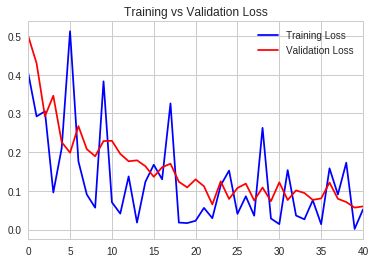

In [0]:
fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)
ax.plot(train_loss, c='b', label='Training Loss')
ax.plot(val_loss1, c='r', label='Validation Loss')
plt.xlim(0,40)

plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.savefig('trainvalloss2.png', dpi=300)
plt.show()

In [0]:
#torch.save(net.state_dict(), '/content/gdrive/My Drive/Data Science/net.pth')

In [0]:
#PATH = '/content/gdrive/My Drive/Data Science'
#torch.save(SentimentRNN, '/content/gdrive/My Drive/Data Science/SentimentRNN.pth')


## **Testing the Network**

In [0]:
from string import punctuation

def tokenize_comment(test_comment):
    
    # Remove URLs
    test_comment = test_comment.replace('https?://[A-Za-z0-9./]+','')
    
    # Keep Hashtag text
    test_comment = test_comment.replace("[^a-zA-Z]", " ")
    
    # Remove whitespace
    #test_comment = test_comment.replace(' ', '')
    
    # Remove 1-2 letter words
    test_comment = test_comment.replace("r'\b\w{1,2}\b", '')
    
    # Remove numbers
    test_comment = test_comment.replace('\d+', '')
    
    # Lowercase
    test_comment = test_comment.lower() # lowercase
    
    # get rid of punctuation
    test_text = ''.join([c for c in test_comment if c not in punctuation])
    
    # Remove Stopwords
    #test_text = ''.join([word for word in test_text.split() if word not in (stop)])
    
    # splitting by spaces
    test_words = [word for word in test_text.split() if word not in (stop)]

    # tokens
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_words if word in vocab])

    return test_ints


In [0]:
# test sequence padding
#seq_length=26
#neg_features = pad_features(test_ints_neg, seq_length)
#pos_features = pad_features(test_ints_pos, seq_length)

In [0]:
# test conversion to tensor and pass into your model
#neg_feature_tensor = torch.from_numpy(neg_features)
#pos_feature_tensor = torch.from_numpy(pos_features)

In [0]:
def predict(net, test_comment, sequence_length=43):
    
    net.eval()
    
    # tokenize review
    test_ints = tokenize_comment(test_comment)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze()) 
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
    # print custom response
    if(pred.item()==1):
        print("Positive comment detected!")
    else:
        print("Negative comment detected.")

In [0]:
# negative test comment
test_comment_neg = "Ashamed of my country today. This ban in hurtful and completely unnecessary. @realDonaldTrump, for someone so seemingly obsessed with national security, why are you stripping the rights of people who just want to protect us?! #transmilitaryban"
test_comment_neg2 = "Mike says this is not good."

# positive test comment
test_comment_pos = "A brilliant recognition by senior Dems of the ability of AOC, Tlaib, Pressley, and Khanna to drag Trump's ilk and put it on blast. Wish Omar had been included too, but oh well."
test_comment_pos2 = "You're not too bad."

In [0]:
# Negative test 1
seq_length=26 # good to use the length that was trained on

predict(net, test_comment_neg, seq_length)

Prediction value, pre-rounding: 0.000236
Negative comment detected.


In [0]:
# Positive Test 1
seq_length=26 

predict(net, test_comment_pos, seq_length)

Prediction value, pre-rounding: 0.000886
Negative comment detected.


In [0]:
# Negative test 2
seq_length=26 
predict(net, test_comment_neg2, seq_length)

Prediction value, pre-rounding: 0.963603
Positive comment detected!


In [0]:
# Positive Test 2
seq_length=26 
predict(net, test_comment_pos2, seq_length)

Prediction value, pre-rounding: 0.000261
Negative comment detected.


## Findings: LSTM RNN round 1


We have some issues with the LSTM model trained on the cleaned tweet that did not contain stop words. Despite reporting an accuracy of 98% we see several False Positives. The shortcomming is later vefied with the test string "Mike says this is not good." The RNN predicts the string as positive which we know makes little sense.


---



![Test Predictions](https://drive.google.com/uc?id=1JO_EbkfTFbGBVsJvCY3wWKJFhAHhDYpa)


---



![Test Statistics](https://drive.google.com/uc?id=1TOKEfk-LRktvVCIXAMLXffnXbekaZUT3) 


---


**Let's rerun the same experiment using the cleaned tweet that contains stopwords.**


## **Findings: LSTM RNN round 2**





It doesn't seem like the presence of stop words impairs the RNN, however there is still a significant number of errors. 


---



![Test Predictions](https://drive.google.com/uc?id=12BPqmTUA2A9L0XdhonarlCDa6KR2tx-t)


---



![Test Statistics](https://drive.google.com/uc?id=1kpgjbDbEojBBU3eGlnX1ZAu3BDjRbGfi)


---



**My suspicion is that there is a class imbalance, I'll make a balanced data frame and rerun the code.**


## **Findings: LSTM RNN Final Round**

Balancing the classes improved the error rate, now our Accuracy actually makes sense. This cell tests a random batch of 30 each time - re-runnning it  several times yielded consistent results. 

**Unfortunately we still fail to idenify the string "Mike says this is not good." as a negative comment.**

![Test Statistics](https://drive.google.com/uc?id=1TUXCwId5UjnCBNW7gbYR_lMKB1RqLTc4) 




# **Conclusion**









1.  The LSTM RNN was better at classifiying tweets as positive or negative as compared to a Random Forest Classifier.
2.  The presence of stop words does not seem to impair the RNN.
3. The RNN does struggle with short and simple negative comments. This could be due to:

    *   The limited vocabulary present in the corpus.
    *   A lack of context or sense.
 

# **Future Work**




*   The next investigative work I plan to do is to feed the RNN an embedding layer trained with Word2Vec or Sense2Vec weights. This could illuminate if the contextual issue is why the test string failed.
*   I would also like to add more data to my dataset, pulling tweets using filters based on product brands and entertainment. 

